# $\text{Arrow Debreu European Option Solver}$

In [2]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import nnls

In [16]:
ticker = 'AAPL' #<-- may enter a differnt ticker
ticker_data = yf.Ticker(ticker)
expiry = ticker_data.options[4] #<-- the grater the index the longer until expiry
print(f'The following are the available expiration dates:\n\n{ticker_data.options}\n')
print('Using Expiry:', expiry)
chain = ticker_data.option_chain(expiry)
calls = chain.calls

The following are the available expiration dates:

('2025-07-11', '2025-07-18', '2025-07-25', '2025-08-01', '2025-08-08', '2025-08-15', '2025-08-22', '2025-09-19', '2025-10-17', '2025-11-21', '2025-12-19', '2026-01-16', '2026-02-20', '2026-03-20', '2026-05-15', '2026-06-18', '2026-09-18', '2026-12-18', '2027-01-15', '2027-06-17', '2027-12-17')

Using Expiry: 2025-08-08


In [21]:
#gets the latest spot and computes the states for payoff matrix columns
spot = ticker_data.history(period='1d')['Close'].iloc[-1]
possible_states = np.linspace( spot - 50, spot + 50, 21, dtype=int)
print('Using Spot:', spot, '\n')
print(f'Will be pricing options for the following spot prices: {possible_states} expiring on {expiry}')


Using Spot: 209.9499969482422 

Will be pricing options for the following spot prices: [159 164 169 174 179 184 189 194 199 204 209 214 219 224 229 234 239 244
 249 254 259] expiring on 2025-08-08


In [35]:
available_strikes = sorted(calls["strike"])
available_strikes = [int(i) for i in available_strikes]
for i in available_strikes:
    int(i)
print('Available Strikes:\n\n', available_strikes)

Available Strikes:

 [140, 145, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 280, 290, 295, 300, 325]


In [40]:
atm_index = min(range(len(available_strikes)), key=lambda i: abs(available_strikes[i] - spot))
lower_bound = max(atm_index - 10, 0)
upper_bound = min(atm_index + 11, len(available_strikes))
chosen_strikes = available_strikes[lower_bound:upper_bound]
chosen_strikes = np.array(chosen_strikes)
print(f'Selected {len(chosen_strikes)} strikes around ATM:', '\n\n', chosen_strikes)

Selected 21 strikes around ATM: 

 [160 165 170 175 180 185 190 195 200 205 210 215 220 225 230 235 240 245
 250 255 260]


In [46]:
chosen_calls = calls[calls['strike'].isin(chosen_strikes)].copy().reset_index(drop=True)
chosen_calls = chosen_calls[['strike', 'bid', 'ask']]
chosen_calls.head()

,strike,bid,ask
0,160.0,50.40,51.20
1,165.0,45.25,46.25
2,170.0,40.30,41.50
3,175.0,35.50,36.60
4,180.0,31.10,31.70


In [47]:
chosen_calls['price_vector'] = (chosen_calls['bid']+chosen_calls['ask'])/2
chosen_calls = chosen_calls[['strike', 'price_vector']]
chosen_calls.head()

,strike,price_vector
0,160.0,50.80
1,165.0,45.75
2,170.0,40.90
3,175.0,36.05
4,180.0,31.40


In [56]:
strikes = chosen_calls["strike"].values
price_vector = chosen_calls["price_vector"].values
print(f'Strikes:\n\n{strikes}', f'\n\nPrices:\n\n {price_vector}')

Strikes:

[160. 165. 170. 175. 180. 185. 190. 195. 200. 205. 210. 215. 220. 225.
 230. 235. 240. 245. 250. 255. 260.] 

Prices:

 [50.8   45.75  40.9   36.05  31.4   26.825 22.375 18.1   14.35  10.9
  7.95   5.525  3.6    2.27   1.405  0.84   0.525  0.35   0.235  0.165
  0.125]


In [67]:
terminal_prices = strikes.copy()
call_payoff_matrix = np.maximum(possible_states - chosen_strikes[:, None], 0)
print(f'Call payoff matrix F:\n\n {call_payoff_matrix}')


Call payoff matrix F:

 [[ 0  4  9 14 19 24 29 34 39 44 49 54 59 64 69 74 79 84 89 94 99]
 [ 0  0  4  9 14 19 24 29 34 39 44 49 54 59 64 69 74 79 84 89 94]
 [ 0  0  0  4  9 14 19 24 29 34 39 44 49 54 59 64 69 74 79 84 89]
 [ 0  0  0  0  4  9 14 19 24 29 34 39 44 49 54 59 64 69 74 79 84]
 [ 0  0  0  0  0  4  9 14 19 24 29 34 39 44 49 54 59 64 69 74 79]
 [ 0  0  0  0  0  0  4  9 14 19 24 29 34 39 44 49 54 59 64 69 74]
 [ 0  0  0  0  0  0  0  4  9 14 19 24 29 34 39 44 49 54 59 64 69]
 [ 0  0  0  0  0  0  0  0  4  9 14 19 24 29 34 39 44 49 54 59 64]
 [ 0  0  0  0  0  0  0  0  0  4  9 14 19 24 29 34 39 44 49 54 59]
 [ 0  0  0  0  0  0  0  0  0  0  4  9 14 19 24 29 34 39 44 49 54]
 [ 0  0  0  0  0  0  0  0  0  0  0  4  9 14 19 24 29 34 39 44 49]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  4  9 14 19 24 29 34 39 44]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  4  9 14 19 24 29 34 39]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  4  9 14 19 24 29 34]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  4  9

In [84]:
state_prices, _ = nnls(call_payoff_matrix, price_vector)

rf = yf.Ticker('^IRX')
rf = rf.history(period='1d')
rf = rf['Close'].iloc[-1] / 100
T=30/365 #<-- we discount about 1 month back
probabilities = state_prices * np.exp(rf*T)
normalized_probabilities = probabilities / np.sum(probabilities)

In [90]:
print(f'Normalized Induced Probabilities:\n\n{normalized_probabilities}\n\n p.s. "np.linalg.lstsq" was resulting in some values being negative so I had to use "scipy.optimize.nnls" i.e non-negative least squares.')

Normalized Induced Probabilities:

[0.         0.04346052 0.         0.03766848 0.01508444 0.02637488
 0.01406376 0.11650491 0.0496152  0.09635482 0.10584256 0.09247121
 0.12138891 0.09906129 0.06064014 0.05220421 0.03682044 0.00670682
 0.         0.         0.02573742]

 p.s. "np.linalg.lstsq" was resulting in some values being negative so I had to use "scipy.optimize.nnls" i.e non-negative least squares.


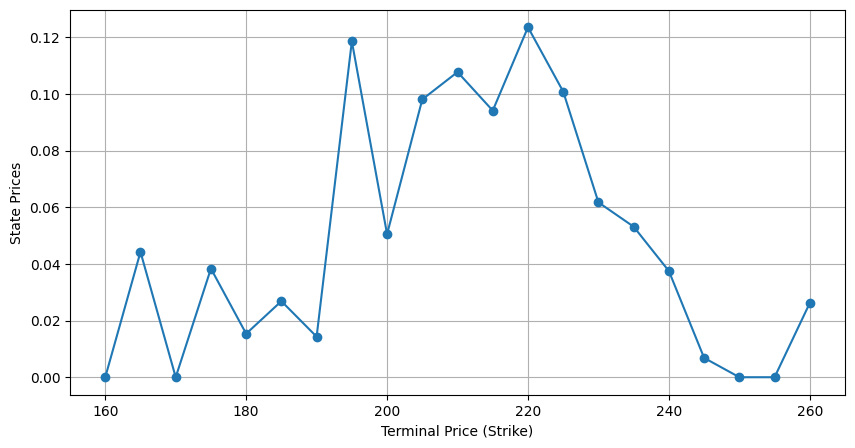

In [93]:
plt.figure(figsize=(10, 5))
plt.plot(terminal_prices, state_prices, marker='o')
plt.xlabel('Terminal Price (Strike)')
plt.ylabel('State Prices')
plt.grid(True)
plt.show()

In [97]:
call_prices = call_payoff_matrix @ state_prices

call_prices = pd.DataFrame({
    'Strike': chosen_strikes,
    '$Call': call_prices
})
call_prices

,Strike,$Call
0,160,50.800000
1,165,45.755428
2,170,40.887786
3,175,36.058482
4,180,31.397880
5,185,26.825530
6,190,22.374867
7,195,18.100033
8,200,14.349992
9,205,10.900002


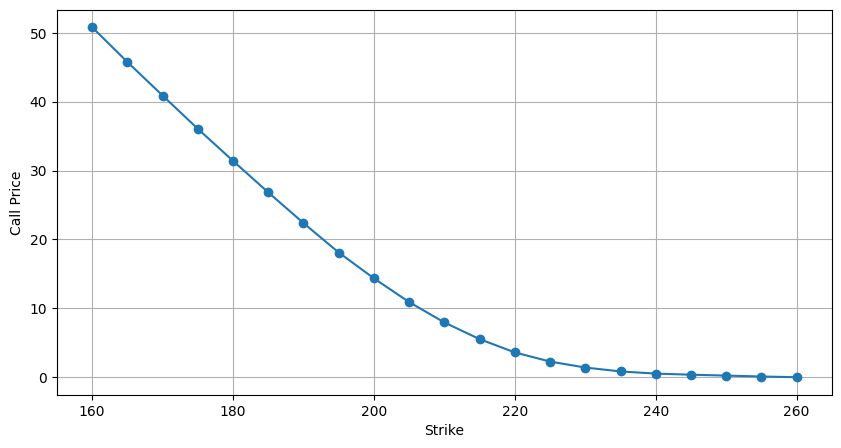

In [102]:
plt.figure(figsize=(10,5))
plt.plot(chosen_strikes, call_prices['$Call'], marker='o')
plt.xlabel('Strike')
plt.ylabel('Call Price')
plt.grid(True)
plt.show()